### Load the package.

In [1]:
import sys; sys.path.append("..") # clean up with a correct install....

from access import *

import pandas as pd
import geopandas as gpd

### Load the examples data.

The single example file contains demand (population) and multiple supplies (primary care physicians and dentists) on a single index (the 2010 Census Tract).

For now, everything is aligned by Census tract, so we'll just pull apart the pieces.  Normally, these might come from different data sources: populations and services are in different locations.  It is the users 

In [2]:
il_med = gpd.read_file("../examples/il_med/il_med.geojson").set_index("geoid")

In [3]:
# Uncomment to download example network time data.
# ! wget https://saxon.harris.uchicago.edu/~jsaxon/il_fca_data/il_times.csv -O ../examples/il_med/il_times.csv

### Load this network distance.

See the main site, for hints on downloading lots of this stuff.

In [4]:
times = pd.read_csv("../examples/il_med/il_times.csv").rename(columns = {"destination" : "dest"})

### Create the access object.

Since we have geometries here, it could be as simple as this:

In [5]:
A = access(demand_df = il_med[["pop", "geometry"]], demand_value = 'pop', 
           supply_df = il_med[["doc", "dentist", "geometry"]], supply_value = ["doc", "dentist"])

In this case, we would _have_ to generate the distance matrix on the fly.

Instead, I'llcreate a slightly more complicated version with all of the possible matrices:

In [6]:
A = access(demand_df = il_med[["pop", "geometry"]], demand_value = 'pop', 
           supply_df = il_med[["doc", "dentist", "geometry"]], supply_value = ["doc", "dentist"], 
           demand_index = True, supply_index = True,
           cost_df   = times,  cost_name = 'cost',
           cost_origin = 'origin', cost_dest = 'dest',
           neighbor_cost_df = times, neighbor_cost_name = 'cost',
           neighbor_cost_origin = 'dest', neighbor_cost_dest = 'origin')

### Add an additional distance measure. 

Now, we can still add a Euclidean distance matrix.  N.B. that this is a very costly operation, but you only have to do it once.  `threshold` is the maximum distance that we will consider.  You can do the distance to polygons (crazy expensive, though we've been moderately careful to make it faster) or just distance between centroids (still not cheap).

In [7]:
A.euclidean_distance(threshold = 250000, centroid_o = True, centroid_d = True)

### Create some weights functions

Of course, you don't _have_ to do this, but it's fun to play with different versions of the access, esp. E2SFCA.

In [8]:
# create the weighting function
# from stepwise weight dictionaries
fn30 = weights.step_fn({10 : 1, 20 : 0.68, 30 : 0.22})
fn60 = weights.step_fn({20 : 1, 40 : 0.68, 60 : 0.22})

# or gaussian weights.
# This could also be done through scipy.stats.norm().pdf, 
#   but that turns out to be unacceptably slow.
gaussian = weights.gaussian(60)

### Ready to roll...

* Now just call the access functions.  
* Each of these will return the corresponding series, but they are also stored in `A.access_df`.  Check out the documentation for the possible arguments.  
* Note that if you call the same function repeatedly, with different arguments, you may want to change the name, to avoid overwriting.
* By default, `access` will be calculated for sequentiall, for all of the supply columns.

In [9]:
A.fca_ratio             (name = "fca",      max_cost = 15)
A.fca_ratio             (name = "fca",      max_cost = 30) # Note - the warning -- good!
A.fca_ratio             (name = "fca60",    max_cost = 60)
A.fca_ratio             (name = "fca90",    max_cost = 90)
A.fca_ratio             (name = "fca100",   max_cost = 100)
A.two_stage_fca         (name = "2sfca",    max_cost = 60)
A.enhanced_two_stage_fca(name = "2sfca30",  weight_fn = fn30)
A.enhanced_two_stage_fca(name = "2sfca60",  weight_fn = fn60)
A.enhanced_two_stage_fca(name = "g2sfca",   weight_fn = gaussian)
A.three_stage_fca       (name = "3sfca")

A.raam(name = "raam");
A.raam(name = "raam_euclidean", tau = 1e5, cost = "euclidean");

/Users/jsaxon/anaconda/envs/py-geo/lib/python3.6/site-packages/ipykernel_launcher.py:1: Warning: Using default supply cost, cost, for fca.
  """Entry point for launching an IPython kernel.
/Users/jsaxon/anaconda/envs/py-geo/lib/python3.6/site-packages/ipykernel_launcher.py:2: Warning: Using default supply cost, cost, for fca.
  
../access/__init__.py:344: Warning: Overwriting fca_doc.
  warnings.warn("Overwriting {}.".format(series.name), Warning)
../access/__init__.py:344: Warning: Overwriting fca_dentist.
  warnings.warn("Overwriting {}.".format(series.name), Warning)
/Users/jsaxon/anaconda/envs/py-geo/lib/python3.6/site-packages/ipykernel_launcher.py:3: Warning: Using default supply cost, cost, for fca60.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jsaxon/anaconda/envs/py-geo/lib/python3.6/site-packages/ipykernel_launcher.py:4: Warning: Using default supply cost, cost, for fca90.
  after removing the cwd from sys.path.
/Users/jsaxon/anaco

### Results time!

Let's get the correlations among measures, and plot a few of them...

In [11]:
A.norm_access_df.corr()

,2sfca30_dentist,2sfca30_doc,2sfca60_dentist,2sfca60_doc,2sfca_dentist,2sfca_doc,3sfca_dentist,3sfca_doc,fca100_dentist,fca100_doc,...,fca90_dentist,fca90_doc,fca_dentist,fca_doc,g2sfca_dentist,g2sfca_doc,raam_dentist,raam_doc,raam_euclidean_dentist,raam_euclidean_doc
2sfca30_dentist,1.000000,0.804254,0.827787,0.754505,0.715730,0.646553,0.831048,0.698255,0.011486,-0.042042,...,0.008652,-0.043214,0.254919,0.130671,0.700192,0.663240,-0.763352,-0.726784,-0.662049,-0.674032
2sfca30_doc,0.804254,1.000000,0.703756,0.775821,0.540593,0.545884,0.524902,0.878616,0.018057,-0.012795,...,0.006537,-0.025937,0.151373,0.186479,0.529131,0.559177,-0.510335,-0.747478,-0.397491,-0.636718
2sfca60_dentist,0.827787,0.703756,1.000000,0.945743,0.940577,0.883602,0.624326,0.573961,0.097012,0.038802,...,0.098617,0.043250,0.339536,0.245387,0.885420,0.874823,-0.733026,-0.782756,-0.656978,-0.721221
2sfca60_doc,0.754505,0.775821,0.945743,1.000000,0.859689,0.887044,0.488192,0.625270,0.098995,0.060739,...,0.102061,0.065023,0.328808,0.309449,0.774036,0.831271,-0.582171,-0.779705,-0.474671,-0.678783
2sfca_dentist,0.715730,0.540593,0.940577,0.859689,1.000000,0.950366,0.580909,0.442943,0.155460,0.093377,...,0.164706,0.106466,0.373012,0.250633,0.912378,0.902407,-0.699405,-0.683203,-0.644666,-0.626530
2sfca_doc,0.646553,0.545884,0.883602,0.887044,0.950366,1.000000,0.477155,0.430556,0.172681,0.131879,...,0.191630,0.152860,0.399951,0.317212,0.807262,0.867688,-0.555490,-0.627037,-0.467363,-0.535799
3sfca_dentist,0.831048,0.524902,0.624326,0.488192,0.580909,0.477155,1.000000,0.661323,0.024001,-0.028201,...,0.014283,-0.035240,0.251037,0.062516,0.611958,0.533713,-0.841088,-0.655556,-0.761204,-0.632420
3sfca_doc,0.698255,0.878616,0.573961,0.625270,0.442943,0.430556,0.661323,1.000000,0.016970,-0.011626,...,-0.010023,-0.041614,0.131962,0.155149,0.471875,0.477849,-0.585711,-0.777999,-0.480165,-0.668901
fca100_dentist,0.011486,0.018057,0.097012,0.098995,0.155460,0.172681,0.024001,0.016970,1.000000,0.987368,...,0.953657,0.938072,0.085447,0.075848,0.121633,0.136512,0.009087,0.038834,0.027351,0.076004
fca100_doc,-0.042042,-0.012795,0.038802,0.060739,0.093377,0.131879,-0.028201,-0.011626,0.987368,1.000000,...,0.937617,0.943717,0.075592,0.080195,0.056745,0.096613,0.082241,0.090726,0.109963,0.131134


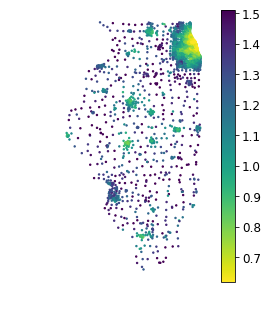

In [18]:
il_map = il_med[["geometry"]].join(A.norm_access_df, how = "inner")

v = "raam_doc"
ax = il_map.plot(v, legend = True, figsize = (5, 5), cmap = "viridis_r", markersize = 2,
                 vmin = il_map[v].quantile(0.05), vmax = il_map[v].quantile(0.95))

ax.set_axis_off()

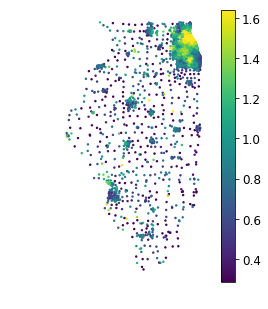

In [21]:
v = "3sfca_dentist"
il_map.plot(v, legend = True, figsize = (5, 5), cmap = "viridis", markersize = 2,
            vmin = il_map[v].quantile(0.05), vmax = il_map[v].quantile(0.95)).set_axis_off()